In [3]:
import auxiliary as aux
import numpy as np
import pickle
from sklearn.svm import LinearSVC
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


non_vehicle_dir = 'Data/non-vehicles/non-vehicles'
vehicle_dir = 'Data/vehicles/vehicles'
pickle_path = 'Data/train_data.p'
model_path = 'model.p'

### Load Data

In [4]:
import glob
import os

def load_data_paths(path):
    image_paths = []
    
    for folder in [ dir for dir in os.listdir(path) if dir[0] != '.']:
        print("Loading images from", folder)
        image_paths += glob.glob(path + '/' + folder + '/*')
        
    return image_paths

In [6]:
# Non-vehicle paths
non_vehicle_path_list = load_data_paths(non_vehicle_dir)
print(len(non_vehicle_path_list),'non-vehicles were loaded.\n')

# Vehicle paths
vehicle_path_list = load_data_paths(vehicle_dir)
print(len(vehicle_path_list),'vehicles were loaded.')

Loading images from Extras
Loading images from GTI
8968 non-vehicles were loaded.

Loading images from GTI_Left
Loading images from GTI_MiddleClose
Loading images from GTI_Far
Loading images from GTI_Right
Loading images from KITTI_extracted
8792 vehicles were loaded.


### Extract Features

Parameters
___

In [2]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 720] # Min and max in y to search in slide_window()

In [5]:
car_features = aux.extract_features(vehicle_path_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

noncar_features = aux.extract_features(non_vehicle_path_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/home/asgalioth/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
car_features[0].shape, noncar_features[0].shape 

((6108,), (6108,))

### Prepare X and Y to train the model

In [7]:
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Shuffle data
rand_state = np.random.randint(0, 100)
X, y = shuffle(scaled_X, y, random_state=rand_state)

data = {'X':X, 'y':y, 'rand_state':rand_state}

#### Run the cells bellow to save or load pickles

In [8]:
with open(pickle_path, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open(pickle_path, 'rb') as handle:
    data = pickle.load(handle)

In [10]:
np.histogram(data['y'], bins=[0, 1, 2])

(array([8968, 8792]), array([0, 1, 2]))

Split the data into training and test

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.2, random_state=rand_state)

## Train a SVC model

In [12]:
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
acc = round(svc.score(X_test, y_test), 4)
print('Test Accuracy of SVC = ', acc)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
12.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


#### Run the cell bellow to sabe the model in a pickle

In [15]:
model = {'model':svc, 'scaler':X_scaler, 'acc': acc, 'rand_state':rand_state, 
         'orient':orient, 'pix_per_cell':pix_per_cell, 'cell_per_block':cell_per_block,
         'spatial_size':spatial_size, 'hist_bins':hist_bins}

with open(model_path, 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open(model_path, 'rb') as handle:
    model = pickle.load(handle)

In [4]:
model

{'acc': 0.99270000000000003,
 'cell_per_block': 2,
 'hist_bins': 16,
 'model': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'orient': 9,
 'pix_per_cell': 8,
 'rand_state': 75,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'spatial_size': (16, 16)}

### Parameters for car finding function

In [5]:
svc = model['model']
X_scaler = model['scaler']
orient = model['orient']
pix_per_cell = model['pix_per_cell']
cell_per_block = model['cell_per_block']
spatial_size = model['spatial_size']
hist_bins = model['hist_bins']

ystart = 400
ystop = 656
scale = 2

## Detecting Cars

In [23]:
np.min(image)

0

/home/asgalioth/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


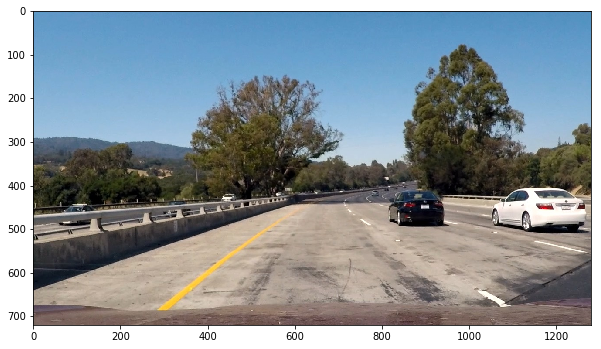

In [55]:
# image = aux.load_image('test_images/bbox-example-image.jpg')
# image = aux.load_image('test_images/car_test.jpg')
image = aux.load_image('test_images/test1.jpg')
# image = aux.load_image('test_images/bbox-example-image.jpg')
draw_image = np.copy(image)

y_start_stop = [500, 720] # Min and max in y to search in slide_window()
box_mult = 3
xy_window=(32*box_mult, 32*box_mult)

windows = aux.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))

hot_windows = aux.search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = aux.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.rcParams["figure.figsize"] = (10, 6)
plt.imshow(window_img)

In [13]:
image = aux.load_image('test_images/test1.jpg')

out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

288

In [12]:
hot_windows

[((288, 500), (352, 564)),
 ((480, 500), (544, 564)),
 ((992, 500), (1056, 564)),
 ((896, 532), (960, 596)),
 ((992, 564), (1056, 628)),
 ((1024, 564), (1088, 628))]